## importing libraries

In [ ]:
!mkdir resources
!wget -q "https://github.com/sobhe/hazm/releases/download/v0.5/resources-0.5.zip" -P resources
!unzip -qq resources/resources-0.5.zip -d resources
!rm -rf /content/4ccae468eb73ybf6c4f4de3075ddb5336
!rm -rf /content/preproc
!rm preprocessing.py utils.py
!mkdir -p /content/preproc
!git clone https://gist.github.com/4ccae468eb73bf6c4f4de3075ddb5336.git /content/preproc/
!mv /content/preproc/* /content/
!rm -rf /content/preproc
!pip install hazm
!pip3 install nltk


rm: cannot remove 'preprocessing.py': No such file or directory
rm: cannot remove 'utils.py': No such file or directory
Cloning into '/content/preproc'...
remote: Enumerating objects: 7, done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 7
Unpacking objects: 100% (7/7), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 316 kB 7.6 MB/s 
     |████████████████████████████████| 1.4 MB 55.1 MB/s 
     |████████████████████████████████| 233 kB 57.5 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394484 sha256=3383415027bc9705a72aa980d4e35ba77b2af5bce6a66fb8414adcd6c40c9ba6
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp37-cp37m-linux_x86_64.whl size=154616 sha256=9580387759bbe8be75331b8b2b2ae37b8a70c6b1454d607e9f67c35c211ad675
  Stored in dire

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import nltk
import pandas as pd
import random
from tqdm import tqdm
import tensorflow as tf

from keras.models import Model
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

from __future__ import unicode_literals
from hazm import *
import hazm

!gdown 12OhtiFHTm121MTqCbRfdFUkP8j1A6dmX


Downloading...
From: https://drive.google.com/uc?id=12OhtiFHTm121MTqCbRfdFUkP8j1A6dmX
To: /content/PerSICK.csv
100% 471k/471k [00:00<00:00, 25.2MB/s]


## useful functions and dictionaries


In [ ]:
import string 
tokenizer = WordTokenizer()
stemmer = Stemmer()
normalizer = Normalizer()
lemmatizer = Lemmatizer()
tagger = POSTagger(model='resources/postagger.model')
parser = DependencyParser(tagger=tagger, lemmatizer=lemmatizer)
labelEncoder = LabelEncoder()

seed=1500
tf.random.set_seed(seed)
random.seed(seed)
np.random.seed(seed)

my_dict={}
my_dict['other'] = ["نفر", "تماشاگر",
                    "افراد", "مردمی", 
                    "برخی", "شخص", 
                    "گروه", "جمعیت", 
                    "انسان"
                    ,"بازیکن","فوتبالیست" ]
my_dict['zan'] = ["زن", "خانم", "دختر", "پیرزن", "بانو", "عروس", "مادر", "ماده"]
my_dict['mard'] =["مرد", "آقا","پسر", "پدر", "پیرمرد", "نر"]
my_dict['koodak'] =["کودک", "بچه", "فرزند", "نوزاد", ]
my_dict['heyvan'] = ["حیوان", "آهو", "سگ", "گربه", "گوزن", "گاو"
, "اسب", "لاک","لاک‌‌پشت", "ماهی",
               "میگو", "میمون", "توله", "گورکن", 
                              "حیوانات", "شیر", "طوطی",
               "موش", "مار", "قورباغه", "فیل", "یوزپلنگ",
                "شامپانزه", "تمساح", "ببر", "خوکچه", "گله"]
               



def cleanUpDataframe(df):
  df = df.drop_duplicates() #drop duplicates
  df = df.dropna() # If any NA values are present, drop that row or column. 
  
  for i in df.index:
    if "/" in df['score'][i]:
      df=df.drop([i])
  df
  df=df.reset_index(drop=True)
  return df


def normalizeSentence(df,column):
  df[column].apply(normalizer.normalize)
  return df[column]


def remove_punctuations(df,column):

    puncs = list(string.punctuation) + [' ', '1', '\xa0', 'ِ', '\u200c', 'ُ', 'َ', '٫', 'ّ', 'ْ', '۰', '۳', '٫']
    for punctuation in puncs:
        df[column] = df[column].replace(punctuation, ' ')
    return df[column]
 

 # finding the subject 

def findSubjectInSntence(sentence):
    subjects = ""
    nodes = parser.parse(word_tokenize(sentence)).nodes
    nodesNumber=len(nodes)
    for i in range(nodesNumber):
        if nodes[i]['rel'] == 'SBJ':
            subjects=stemmer.stem(nodes[i]['lemma'])
            break
    return subjects


def stemAndNormlizeDic(dic):
  for key in dic:
    value = []
    for word in dic[key]:
      normal_stemmed = stemmer.stem(normalizer.normalize(word))
      value.append(normal_stemmed)
      dic[key] = value
  return dic      



## Downloading dataset

In [ ]:

df = pd.read_csv('/content/PerSICK.csv')
df


,score,sentence1,sentence2
0,4.5,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,گروهی از پسران در حیاط بازی می کنند و مردی در ...
1,3.2,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
2,4.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,بچه ها در بیرون از خانه و در کنار یک مرد با لب...
3,3.4,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
4,3.7,پسران جوان در فضای باز بازی می کنند و مرد در ه...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
...,...,...,...
3097,2.8,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می دود
3098,4.8,سگ سیاه و سفید در فضای بیرون می دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است
3099,3.8,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده اند
3100,3.4,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کنا...,یک زن و مرد روی حاشیه ایستاده اند


##cleanUpDataframe

In [ ]:
df=cleanUpDataframe(df)

In [ ]:

df["score"] = pd.to_numeric(df["score"], downcast="float") #cast to float
df['score'] = df['score'].round(0) #rounding score
df

,score,sentence1,sentence2
0,4.0,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...,گروهی از پسران در حیاط بازی می کنند و مردی در ...
1,3.0,گروهی از کودکان در خانه مشغول بازی هستند و هیچ...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
2,5.0,پسران جوان در فضای باز بازی می کنند و مرد در ه...,بچه ها در بیرون از خانه و در کنار یک مرد با لب...
3,3.0,بچه ها در بیرون از خانه و در کنار یک مرد با لب...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
4,4.0,پسران جوان در فضای باز بازی می کنند و مرد در ه...,گروهی از بچه ها در حیاط بازی می کنند و پیرمردی...
...,...,...,...
3092,3.0,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می دود
3093,5.0,سگ سیاه و سفید در فضای بیرون می دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است
3094,4.0,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده اند
3095,3.0,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کنا...,یک زن و مرد روی حاشیه ایستاده اند


## pre processing

###remove puncuation

In [ ]:

df["sentence1"] =remove_punctuations(df,"sentence1")
df["sentence2"] = remove_punctuations(df,"sentence2")


### normilzling

In [ ]:

normalized_dataFrame = df.copy()
normalized_dataFrame['sentence1'] = normalizeSentence(normalized_dataFrame,"sentence1")
normalized_dataFrame['sentence2'] = normalizeSentence(normalized_dataFrame,"sentence2")
sentence1 = normalized_dataFrame['sentence1'].tolist()
sentence2 = normalized_dataFrame['sentence2'].tolist()

#finding length of normalized df (for padding )
length1 = normalized_dataFrame['sentence1'].str.split().str.len().max()
length2 = normalized_dataFrame['sentence2'].str.split().str.len().max()
maxLength = length1 if length2 < length1 else length2


## find subject

example of using parser

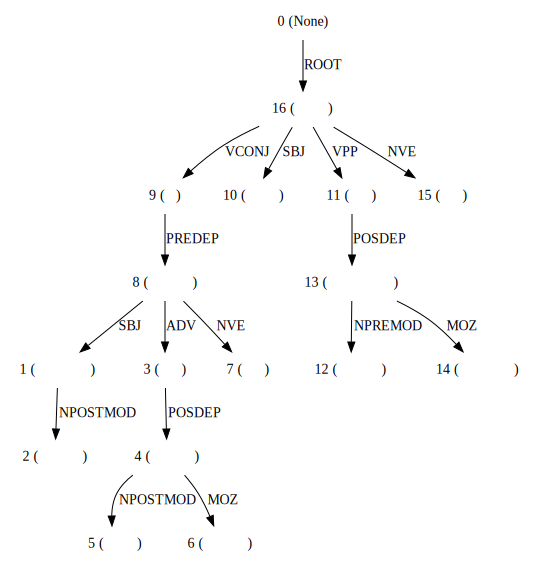

In [ ]:
parser.parse(word_tokenize(normalized_dataFrame["sentence1"][2]))


In [ ]:
nodes = parser.parse(word_tokenize(normalized_dataFrame["sentence1"][2])).nodes
print(nodes[1]['rel'])
print(nodes[1]['lemma'])

SBJ
پسر


example of finding subj


In [ ]:
print(findSubjectInSntence(normalized_dataFrame["sentence1"][0]))
print(normalized_dataFrame["sentence1"][0])

گروه
گروهی از بچه ها در حیاط بازی می کنند و پیرمردی در پس زمینه ایستاده است


In [ ]:

# for i in tqdm(range(3097)):
#     df_sbj.at[ i, 'sbj1'] = findSubjectInSntence(normalized_dataFrame["sentence1"][ i])
#     df_sbj.at[ i, 'sbj2'] = findSubjectInSntence(normalized_dataFrame["sentence2"][ i])
#     df_sbj.to_csv('/content/mydata.csv', index=False)
#     !cp /content/mydata.csv /content/drive/MyDrive 
# df_sbj.to_csv('/content/mydata.csv', index=False)
# !cp /content/mydata.csv /content/drive/MyDrive


### downloading data with subject

In [ ]:
!gdown 1UU8b76q_oln3fbNvSGCeacernxsX2Nx1
df_sbj = pd.read_csv('/content/mydata.csv')
df_sbj['score']=df['score']
df_sbj


Downloading...
From: https://drive.google.com/uc?id=1UU8b76q_oln3fbNvSGCeacernxsX2Nx1
To: /content/mydata.csv
100% 553k/553k [00:00<00:00, 121MB/s]


,score,sentence1,sentence2,sbj1,sbj2,subject_label
0,4.0,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروهی از پسران در حیاط بازی می‌کنند و مردی در...,گروه,گروه,other
1,3.0,گروهی از کودکان در خانه مشغول بازی هستند و هی...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروه,گروه,other
2,5.0,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,پسر,بچه,NaN
3,3.0,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,بچه,گروه,NaN
4,4.0,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,پسر,گروه,NaN
...,...,...,...,...,...,...
3092,3.0,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می‌دود,سگ,سگ,heyvan
3093,5.0,سگ سیاه و سفید در فضای بیرون می‌دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,سگ,سگ,heyvan
3094,4.0,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,zan
3095,3.0,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کن...,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,zan


In [ ]:
# df_sbj.to_csv('/content/mydata.csv', index=False)

### classification

In [ ]:
print (my_dict.items())

dict_items([('other', ['نفر', 'تماشاگر', 'افراد', 'مردمی', 'برخی', 'شخص', 'گروه', 'جمعیت', 'انسان', 'بازیکن', 'فوتبالیست']), ('zan', ['زن', 'خانم', 'دختر', 'پیرزن', 'بانو', 'عروس', 'مادر', 'ماده']), ('mard', ['مرد', 'آقا', 'پسر', 'پدر', 'پیرمرد', 'نر']), ('koodak', ['کودک', 'بچه', 'فرزند', 'نوزاد']), ('heyvan', ['حیوان', 'آهو', 'سگ', 'گربه', 'گوزن', 'گاو', 'اسب', 'لاک', 'لاک\u200c\u200cپشت', 'ماهی', 'میگو', 'میمون', 'توله', 'گورکن', 'حیوانات', 'شیر', 'طوطی', 'موش', 'مار', 'قورباغه', 'فیل', 'یوزپلنگ', 'شامپانزه', 'تمساح', 'ببر', 'خوکچه', 'گله', 'دشوند'])])


In [ ]:
my_dict=stemAndNormlizeDic(my_dict)

### subject classification

In [ ]:
df_sbj["subject_label"] = "N/A"
sentence1subj=df_sbj["sbj1"]
sentence2subj=df_sbj["sbj2"]
for i in df_sbj.index:
  subject1 = sentence1subj[i]
  subject2 = sentence2subj[i]
  for key in my_dict:
    if subject1 in my_dict[key] and  subject2 in my_dict[key]:
      df_sbj.at[i, "subject_label"] = key
              
df_sbj

,score,sentence1,sentence2,sbj1,sbj2,subject_label
0,4.0,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروهی از پسران در حیاط بازی می‌کنند و مردی در...,گروه,گروه,other
1,3.0,گروهی از کودکان در خانه مشغول بازی هستند و هی...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروه,گروه,other
2,5.0,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,پسر,بچه,N/A
3,3.0,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,بچه,گروه,N/A
4,4.0,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,پسر,گروه,N/A
...,...,...,...,...,...,...
3092,3.0,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می‌دود,سگ,سگ,heyvan
3093,5.0,سگ سیاه و سفید در فضای بیرون می‌دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,سگ,سگ,heyvan
3094,4.0,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,zan
3095,3.0,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کن...,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,zan


In [ ]:
# labeling the scores 1 to 5
df['score'] = df['score'].replace(1.0, "1")
df['score'] = df['score'].replace(2.0, "2")
df['score'] = df['score'].replace(3.0, "3")
df['score'] = df['score'].replace(4.0, "4")
df['score'] = df['score'].replace(5.0, "5")
df_sbj['score']=df['score']

df_encoded = df_sbj.copy()
df_encoded[['score']] = df_sbj[['score']].apply(labelEncoder.fit_transform, axis=0)
df_encoded  

df_encoded["subject_label"] = df_encoded["subject_label"].replace("mard",0)
df_encoded["subject_label"] = df_encoded["subject_label"].replace("zan",1)
df_encoded["subject_label"] = df_encoded["subject_label"].replace("koodak",2)
df_encoded["subject_label"] = df_encoded["subject_label"].replace("heyvan",3)
df_encoded["subject_label"] = df_encoded["subject_label"].replace("other",4)
df_encoded["subject_label"] = df_encoded["subject_label"].replace("N/A",5)

df_encoded

,score,sentence1,sentence2,sbj1,sbj2,subject_label
0,3,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروهی از پسران در حیاط بازی می‌کنند و مردی در...,گروه,گروه,4
1,2,گروهی از کودکان در خانه مشغول بازی هستند و هی...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروه,گروه,4
2,4,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,پسر,بچه,5
3,2,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,بچه,گروه,5
4,3,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,پسر,گروه,5
...,...,...,...,...,...,...
3092,2,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می‌دود,سگ,سگ,3
3093,4,سگ سیاه و سفید در فضای بیرون می‌دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,سگ,سگ,3
3094,3,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,1
3095,2,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کن...,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,1


In [ ]:

tk = Tokenizer(
    num_words=1000,
    filters='\u200c!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n،ًٌٍَُِ',
    split=' ',
    oov_token='UNK'
)
tk.fit_on_texts(sentence1+sentence2)


In [ ]:
X1_toIndex = tk.texts_to_sequences(sentence1)
X2_toIndex =tk.texts_to_sequences(sentence2)

print(sentence1[1])
print(sentence1[2])
print(sentence1[3])

print(X1_toIndex[1])
print(X1_toIndex[2])
print(X1_toIndex[3])

گروهی از کودکان در خانه مشغول بازی هستند و هیچ مردی در پس زمینه ایستاده نیست
پسران جوان در فضای باز بازی می کنند و مرد در همان نزدیکی لبخند می زند
بچه ها در بیرون از خانه و در کنار یک مرد با لبخند بازی می کنند
[86, 10, 264, 2, 282, 121, 21, 23, 7, 24, 9, 2, 274, 304, 28, 99]
[265, 92, 2, 164, 101, 21, 6, 31, 7, 14, 2, 525, 226, 373, 6, 40]
[53, 34, 2, 77, 10, 282, 7, 2, 50, 4, 14, 8, 373, 21, 6, 31]


In [ ]:
df_sbj

,score,sentence1,sentence2,sbj1,sbj2,subject_label
0,4,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروهی از پسران در حیاط بازی می‌کنند و مردی در...,گروه,گروه,other
1,3,گروهی از کودکان در خانه مشغول بازی هستند و هی...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,گروه,گروه,other
2,5,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,پسر,بچه,N/A
3,3,بچه‌ها در بیرون از خانه و در کنار یک مرد با ل...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,بچه,گروه,N/A
4,4,پسران جوان در فضای باز بازی می‌کنند و مرد در ...,گروهی از بچه‌ها در حیاط بازی می‌کنند و پیرمرد...,پسر,گروه,N/A
...,...,...,...,...,...,...
3092,3,سگ سیاه و سفید روی حیاطی سبز نشسته است,سگ سیاه و سفید در حیاطی سبز می‌دود,سگ,سگ,heyvan
3093,5,سگ سیاه و سفید در فضای بیرون می‌دوید,یک سگ سیاه و سفید در فضای باز در حال دویدن است,سگ,سگ,heyvan
3094,4,یک زن و مرد در حال پریدن روی حاشیه هستند,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,zan
3095,3,زنی با پیراهن آبی و پاشنه بلند در پیاده رو کن...,یک زن و مرد روی حاشیه ایستاده‌اند,زن,زن,zan


### Finding max length  of dataset sentences

In [ ]:

print("The maximum number of words in dataset  : " +  str(maxLength))

The maximum number of words in dataset  : 27


add padding

In [ ]:
X_pad_1 = pad_sequences(X1_toIndex, maxlen=maxLength, padding='post')
X_pad_2 = pad_sequences(X2_toIndex, maxlen=maxLength, padding='post')

print("shape1: ", X_pad_1.shape)
print("shape2: ", X_pad_2.shape)

print (X1_toIndex[1])
print (X_pad_1[1])


shape1:  (3097, 27)
shape2:  (3097, 27)
[86, 10, 264, 2, 282, 121, 21, 23, 7, 24, 9, 2, 274, 304, 28, 99]
[ 86  10 264   2 282 121  21  23   7  24   9   2 274 304  28  99   0   0
   0   0   0   0   0   0   0   0   0]


### creating one-hot setes

In [ ]:
#onehot set

X_OH1 = to_categorical(X_pad_1, num_classes=1000)
X_OH2 = to_categorical(X_pad_2, num_classes=1000)
X_OH = np.array(list(zip(X_OH1, X_OH2)))
Y_score_OH = to_categorical(np.array(df_encoded["score"].tolist()), num_classes=5)
Y_sbj_OH = to_categorical(np.array(df_encoded["subject_label"].tolist()), num_classes=6)
Y_OH = np.concatenate((Y_score_OH, Y_sbj_OH), axis=1)
print(X_OH1.shape)
print(Y_score_OH.shape)
print(Y_sbj_OH.shape)


(3097, 27, 1000)
(3097, 5)
(3097, 6)


In [ ]:
X_OH

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0., 0., ..., 0., 0., 0.],
         [1., 0.

### Splitting dataset

In [ ]:

X_train, X_test, Y_train, Y_test = train_test_split(X_OH, Y_OH, test_size=0.1, random_state=seed)
X1_train, X2_train = X_train[:, 0], X_train[:, 1]
X1_test, X2_test = X_test[:, 0], X_test[:, 1]

print("\nX1 train: ", X1_train.shape,"\n","*"*100, "\nX2 train: ", X2_train.shape,"\n","*"*100, "\nX1 test: ", X1_test.shape,"\n","*"*100, "\nX2 test: ",
      X2_test.shape,"\n","*"*100, "\nY train: ", Y_train.shape,"\n","*"*100, "\nY test: ", Y_test.shape)


X1 train:  (2787, 27, 1000) 
 **************************************************************************************************** 
X2 train:  (2787, 27, 1000) 
 **************************************************************************************************** 
X1 test:  (310, 27, 1000) 
 **************************************************************************************************** 
X2 test:  (310, 27, 1000) 
 **************************************************************************************************** 
Y train:  (2787, 11) 
 **************************************************************************************************** 
Y test:  (310, 11)


# *Model*

### simple+relu


In [ ]:
tf.keras.backend.clear_session()


def simpleRNN_model(input1, input2):
    input1_ = layers.SimpleRNN(128, activation="relu")(input1)
    input2_ = layers.SimpleRNN(128, activation="relu")(input2)

    concat_out = layers.concatenate([input1_, input2_], axis=-1)
    return concat_out


input1 = layers.Input(shape=X1_train.shape[1:])
input2 = layers.Input(shape=X2_train.shape[1:])
layer_in = simpleRNN_model(input1, input2)

flatten = layers.Flatten()(layer_in)
dense1 = layers.Dense(64, activation='relu')(flatten)
dense2 = layers.Dense(32, activation='relu')(dense1)
output = layers.Dense(11, activation='sigmoid', name='output1')(dense2)

model = Model(inputs=[input1, input2], outputs=output)
print(model.summary())
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 128)          144512      ['input_1[0][0]']                
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 128)          144512      ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([X1_train, X2_train], Y_train, epochs=10, verbose=1, batch_size=10, validation_data=([X1_test, X2_test], Y_test))

Epoch 1/10
279/279 [==============================] - 15s 43ms/step - loss: 0.4333 - categorical_accuracy: 0.2293 - val_loss: 0.4194 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
279/279 [==============================] - 15s 53ms/step - loss: 0.4183 - categorical_accuracy: 0.1773 - val_loss: 0.4121 - val_categorical_accuracy: 0.3871
Epoch 3/10
279/279 [==============================] - 17s 61ms/step - loss: 0.4086 - categorical_accuracy: 0.2085 - val_loss: 0.3992 - val_categorical_accuracy: 0.4194
Epoch 4/10
279/279 [==============================] - 11s 39ms/step - loss: 0.3865 - categorical_accuracy: 0.1826 - val_loss: 0.3775 - val_categorical_accuracy: 0.1419
Epoch 5/10
279/279 [==============================] - 16s 59ms/step - loss: 0.3908 - categorical_accuracy: 0.1794 - val_loss: 0.3699 - val_categorical_accuracy: 0.1387
Epoch 6/10
279/279 [==============================] - 13s 45ms/step - loss: 0.3709 - categorical_accuracy: 0.1701 - val_loss: 0.4053 - val_categorical_accur

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


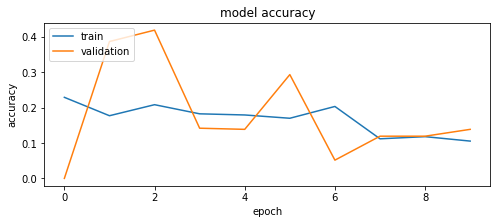

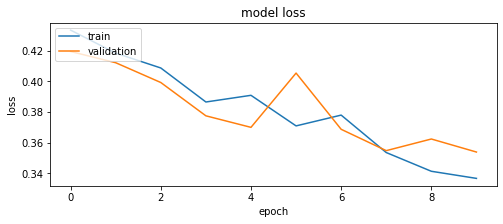

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


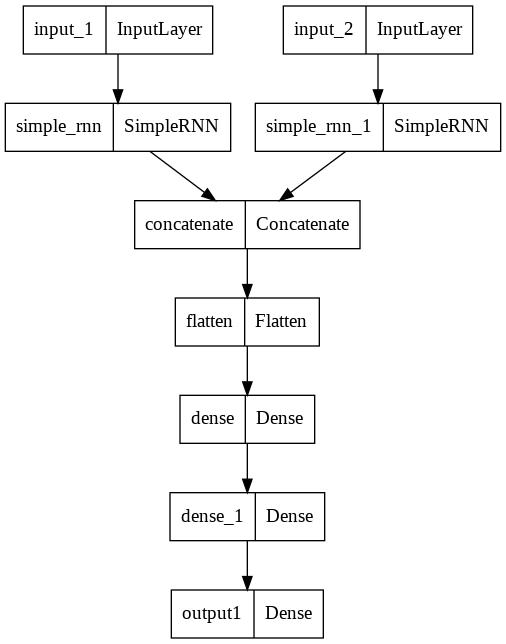

In [ ]:
tf.keras.utils.plot_model(model, "simple.jpg")

### simple+tan


In [ ]:
tf.keras.backend.clear_session()


def simpleRNN_model(input1, input2):
    input1_ = layers.SimpleRNN(128, activation="tanh")(input1)
    input2_ = layers.SimpleRNN(128, activation="tanh")(input2)

    concat_out = layers.concatenate([input1_, input2_], axis=-1)
    return concat_out


input1 = layers.Input(shape=X1_train.shape[1:])
input2 = layers.Input(shape=X2_train.shape[1:])
layer_in = simpleRNN_model(input1, input2)

flatten = layers.Flatten()(layer_in)
dense1 = layers.Dense(114, activation='relu')(flatten)
dense2 = layers.Dense(64, activation='relu')(dense1)
output = layers.Dense(11, activation='sigmoid', name='output1')(dense2)

model = Model(inputs=[input1, input2], outputs=output)
print(model.summary())
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 128)          144512      ['input_1[0][0]']                
                                                                                                  
 simple_rnn_1 (SimpleRNN)       (None, 128)          144512      ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([X1_train, X2_train], Y_train, epochs=10, verbose=1, batch_size=10, validation_data=([X1_test, X2_test], Y_test))

Epoch 1/10
279/279 [==============================] - 8s 22ms/step - loss: 0.4258 - categorical_accuracy: 0.1884 - val_loss: 0.4076 - val_categorical_accuracy: 0.3677
Epoch 2/10
279/279 [==============================] - 6s 21ms/step - loss: 0.3751 - categorical_accuracy: 0.0861 - val_loss: 0.3497 - val_categorical_accuracy: 0.0581
Epoch 3/10
279/279 [==============================] - 7s 24ms/step - loss: 0.3739 - categorical_accuracy: 0.0976 - val_loss: 0.3966 - val_categorical_accuracy: 0.2258
Epoch 4/10
279/279 [==============================] - 6s 22ms/step - loss: 0.4013 - categorical_accuracy: 0.1396 - val_loss: 0.4079 - val_categorical_accuracy: 0.0129
Epoch 5/10
279/279 [==============================] - 6s 22ms/step - loss: 0.4063 - categorical_accuracy: 0.1536 - val_loss: 0.4012 - val_categorical_accuracy: 0.4065
Epoch 6/10
279/279 [==============================] - 6s 22ms/step - loss: 0.4052 - categorical_accuracy: 0.2135 - val_loss: 0.3988 - val_categorical_accuracy: 0.406

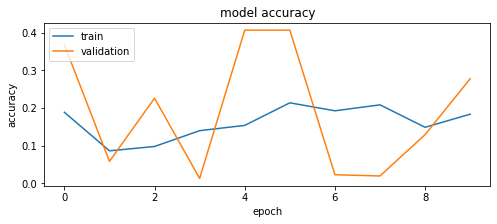

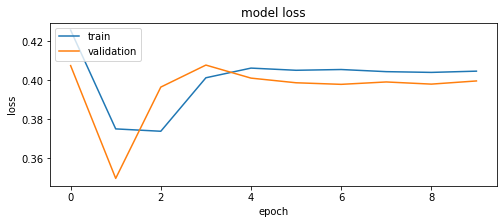

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### LSTM+relu


In [ ]:
tf.keras.backend.clear_session()

optmzr = tf.keras.optimizers.Adam(learning_rate=0.001)

def LSTM_Model(input1, input2):
    input1_ = layers.LSTM(128, activation="relu")(input1)
    input2_ = layers.LSTM(128, activation="relu")(input2)

    concat_out = layers.concatenate([input1_, input2_], axis=-1)
    return concat_out


input1 = layers.Input(shape=X1_train.shape[1:])
input2 = layers.Input(shape=X2_train.shape[1:])
layer_in = LSTM_Model(input1, input2)

flatten = layers.Flatten()(layer_in)
dense1 = layers.Dense(114, activation='relu')(flatten)
dense2 = layers.Dense(64, activation='relu')(dense1)
output = layers.Dense(11, activation='sigmoid', name='output1')(dense2)

model = Model(inputs=[input1, input2], outputs=output)
print(model.summary())
model.compile(loss="binary_crossentropy", optimizer=optmzr, metrics=["categorical_accuracy"])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          578048      ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 128)          578048      ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([X1_train, X2_train], Y_train, epochs=10, verbose=1, batch_size=15, validation_data=([X1_test, X2_test], Y_test))

Epoch 1/10
186/186 [==============================] - 19s 94ms/step - loss: 0.4508 - categorical_accuracy: 0.2042 - val_loss: 0.4152 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
186/186 [==============================] - 20s 106ms/step - loss: 0.4141 - categorical_accuracy: 0.1773 - val_loss: 0.4050 - val_categorical_accuracy: 0.0806
Epoch 3/10
186/186 [==============================] - 19s 104ms/step - loss: 0.3655 - categorical_accuracy: 0.1216 - val_loss: 0.3548 - val_categorical_accuracy: 0.0742
Epoch 4/10
186/186 [==============================] - 19s 103ms/step - loss: 0.3283 - categorical_accuracy: 0.0804 - val_loss: 0.3252 - val_categorical_accuracy: 0.0645
Epoch 5/10
186/186 [==============================] - 19s 100ms/step - loss: 0.2941 - categorical_accuracy: 0.0517 - val_loss: 0.3323 - val_categorical_accuracy: 0.0516
Epoch 6/10
186/186 [==============================] - 19s 101ms/step - loss: 0.2721 - categorical_accuracy: 0.0359 - val_loss: 0.3218 - val_categorical_

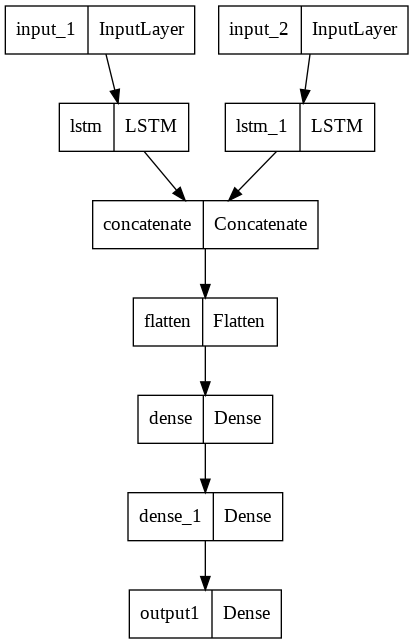

In [ ]:
tf.keras.utils.plot_model(model, "LSTM.png")

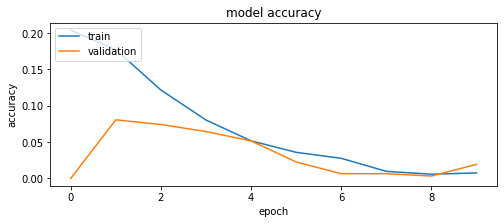

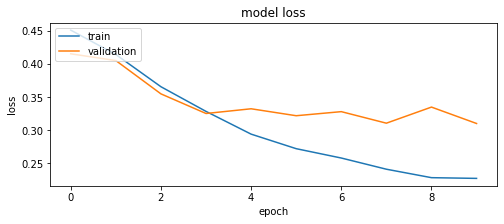

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


## GRU+relu


In [ ]:
tf.keras.backend.clear_session()

optmzr = tf.keras.optimizers.Adam(learning_rate=0.0005)


def GRU_model(input1, input2):
    input1_ = layers.GRU(128)(input1)
    input2_ = layers.GRU(128)(input2)
   

    concat_out = layers.concatenate([input1_, input2_], axis=-1)
    return concat_out


input1 = layers.Input(shape=X1_train.shape[1:])
input2 = layers.Input(shape=X2_train.shape[1:])
layer_in = GRU_model(input1, input2)

flatten = layers.Flatten()(layer_in)
dense1 = layers.Dense(64, activation='relu')(flatten)
dense2 = layers.Dense(32, activation='relu')(dense1)
output = layers.Dense(11, activation='sigmoid', name='output1')(dense2)

model = Model(inputs=[input1, input2], outputs=output)
print(model.summary())
model.compile(loss="binary_crossentropy", optimizer=optmzr, metrics=["categorical_accuracy"])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 gru (GRU)                      (None, 128)          433920      ['input_1[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 128)          433920      ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([X1_train, X2_train], Y_train, epochs=10, verbose=1, batch_size=10, validation_data=([X1_test, X2_test], Y_test))

Epoch 1/10
279/279 [==============================] - 23s 73ms/step - loss: 0.4501 - categorical_accuracy: 0.1615 - val_loss: 0.4152 - val_categorical_accuracy: 0.0032
Epoch 2/10
279/279 [==============================] - 20s 71ms/step - loss: 0.4185 - categorical_accuracy: 0.2519 - val_loss: 0.4151 - val_categorical_accuracy: 0.4226
Epoch 3/10
279/279 [==============================] - 20s 72ms/step - loss: 0.4164 - categorical_accuracy: 0.2210 - val_loss: 0.4105 - val_categorical_accuracy: 0.1452
Epoch 4/10
279/279 [==============================] - 20s 72ms/step - loss: 0.3948 - categorical_accuracy: 0.1909 - val_loss: 0.3693 - val_categorical_accuracy: 0.1516
Epoch 5/10
279/279 [==============================] - 20s 72ms/step - loss: 0.3494 - categorical_accuracy: 0.0628 - val_loss: 0.3522 - val_categorical_accuracy: 0.1452
Epoch 6/10
279/279 [==============================] - 20s 71ms/step - loss: 0.3303 - categorical_accuracy: 0.0739 - val_loss: 0.3423 - val_categorical_accuracy:

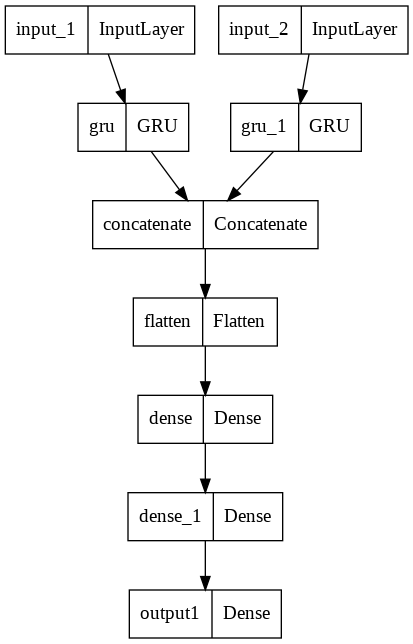

In [ ]:
tf.keras.utils.plot_model(model, "GRU.png")

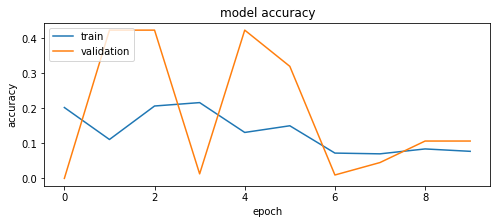

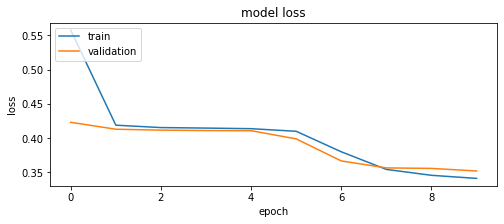

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


GRU + Relu  with diffrent learning rate

In [ ]:
tf.keras.backend.clear_session()

optmzr = tf.keras.optimizers.Adam(learning_rate=0.0005)


def GRU_model(input1, input2):
    input1_ = layers.GRU(256)(input1)
    input2_ = layers.GRU(256)(input2)
   

    concat_out = layers.concatenate([input1_, input2_], axis=-1)
    return concat_out


input1 = layers.Input(shape=X1_train.shape[1:])
input2 = layers.Input(shape=X2_train.shape[1:])
layer_in = GRU_model(input1, input2)

flatten = layers.Flatten()(layer_in)
dense1 = layers.Dense(128, activation='relu')(flatten)
dense2 = layers.Dense(64, activation='relu')(dense1)
dense3 = layers.Dense(32, activation='relu')(flatten)
output = layers.Dense(11, activation='sigmoid', name='output1')(dense3)

model = Model(inputs=[input1, input2], outputs=output)
print(model.summary())
model.compile(loss="binary_crossentropy", optimizer=optmzr, metrics=["categorical_accuracy"])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 27, 1000)]   0           []                               
                                                                                                  
 gru (GRU)                      (None, 256)          966144      ['input_1[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 256)          966144      ['input_2[0][0]']                
                                                                                              

In [ ]:
history = model.fit([X1_train, X2_train], Y_train, epochs=10, verbose=1, batch_size=10, validation_data=([X1_test, X2_test], Y_test))

Epoch 1/10
279/279 [==============================] - 48s 161ms/step - loss: 0.4377 - categorical_accuracy: 0.2332 - val_loss: 0.4173 - val_categorical_accuracy: 0.0000e+00
Epoch 2/10
279/279 [==============================] - 43s 155ms/step - loss: 0.4182 - categorical_accuracy: 0.2009 - val_loss: 0.4101 - val_categorical_accuracy: 0.4226
Epoch 3/10
279/279 [==============================] - 42s 150ms/step - loss: 0.3637 - categorical_accuracy: 0.1102 - val_loss: 0.3424 - val_categorical_accuracy: 0.0226
Epoch 4/10
279/279 [==============================] - 41s 148ms/step - loss: 0.3323 - categorical_accuracy: 0.0344 - val_loss: 0.3318 - val_categorical_accuracy: 0.0032
Epoch 5/10
279/279 [==============================] - 43s 154ms/step - loss: 0.3217 - categorical_accuracy: 0.0305 - val_loss: 0.3300 - val_categorical_accuracy: 0.1000
Epoch 6/10
279/279 [==============================] - 44s 158ms/step - loss: 0.3148 - categorical_accuracy: 0.0409 - val_loss: 0.3282 - val_categorical

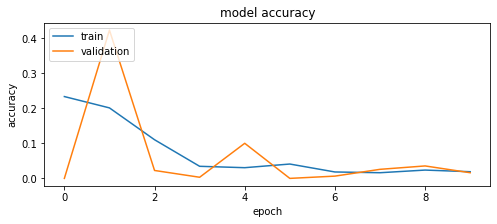

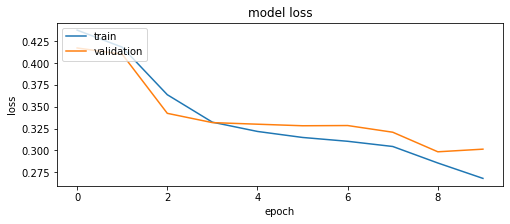

In [ ]:
plt.figure(figsize=(8, 3))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


plt.figure(figsize=(8, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
